# Kaggle competition - What's cooking 
### ingredients의 recipe list를 이용하여 cuisine을 맞추는 분류 문제
### Goal
1. f1 score를 최대로 올리는 것을 목표로 한다.
    - 첫째, tfidfVectorizer를 이용하여 metrix를 만든 후 modeling
    - 둘째, PCA를 이용하여 modeling
2. word2vec을 이용하여 simple bot을 구현한다.

In [1]:
import pandas as pd
import numpy as np

% matplotlib inline
import matplotlib.pyplot as plt

from collections import Counter
from pprint import pprint

pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)

import re
from nltk.stem import WordNetLemmatizer

# 모델의 최적의 파라미터를 찾아주는 그리드서치
from sklearn.model_selection import GridSearchCV

# Model modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

# estimate를 위한 modules
from sklearn.model_selection import cross_val_score
from sklearn import cross_validation
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# featrures를 encoding 하기 위한 modules
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Data set을 나누기 위한 modules
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from gensim.models import word2vec

c:\Python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\Python36\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
c:\Python36\lib\site-packages\scipy\sparse\sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## I. DATA LOAD

In [2]:
train = pd.read_json('train.json', encoding = 'UTF-8')
test = pd.read_json('test.json', encoding = 'UTF-8')

COPY

In [3]:
df = train.copy()

print(df.shape)
df.tail(2)

(39774, 3)


,cuisine,id,ingredients
39772,chinese,41882,"[boneless chicken skinless thigh, minced garli..."
39773,mexican,2362,"[green chile, jalapeno chilies, onions, ground..."


## II. DATA 탐색 (Before Pre-processing)

#### 1) Count

In [4]:
df.count()

cuisine        39774
id             39774
ingredients    39774
dtype: int64

#### 2) Number of NaNs for each column

In [5]:
df.isnull().sum()

cuisine        0
id             0
ingredients    0
dtype: int64

#### 3) Cuisine Types

In [6]:
print('Cusine은 {}개 입니다.'.format(len(df.cuisine.value_counts())))
df.cuisine.value_counts()

Cusine은 20개 입니다.


italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

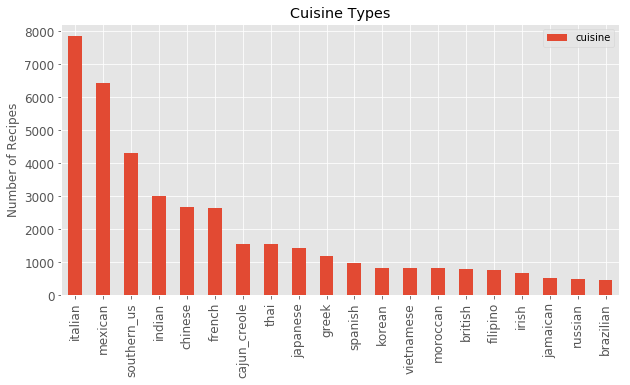

In [7]:
# cuisine type 시각화

plt.style.use('ggplot')
df.cuisine.value_counts().plot(kind = 'bar',
                              title='Cuisine Types',
                              figsize=(10,5),
                              legend=True,
                              fontsize=12)
plt.ylabel("Number of Recipes", fontsize=12)
plt.show()

#### 4) Ingredients Types

In [5]:
### 각 row 마다의 recipe 별 ingredient를 count하기 위한 작업

# 여기서는 ingredient가 각 1개씩 count 될 것이다.
bag_of_ingredients = [Counter(ingredient) for ingredient in df.ingredients]

# 각 ingredients의 종류별 개수
sum_of_ingredients = sum(bag_of_ingredients, Counter())

########################################################################################

### sum_of_ingredients를 dataframe에 넣기 위한 작업

# dict -> list -> dataframe
sum_of_ingredients_dict = dict(sum_of_ingredients)
sum_of_ingredients_list = list(sum_of_ingredients_dict.items())

ingredients_df = pd.DataFrame(sum_of_ingredients_list)
ingredients_df.columns = ['ingredient', 'count']
ingredients_df.tail(2)

print('전처리 전 ingredient는 총 {}개 입니다.'.format(len(ingredients_df)))

전처리 전 ingredient는 총 6714개 입니다.


In [8]:
ingredients_df.head(20)

,ingredient,count
0,romaine lettuce,270
1,black olives,229
2,grape tomatoes,228
3,garlic,7380
4,pepper,4438
5,purple onion,1896
6,seasoning,137
7,garbanzo beans,148
8,feta cheese crumbles,358
9,plain flour,154


## III. Pre-processing

1. 대문자를 소문자로
2. 상품명 제거 : Oscar Mayer Deli Fresh Smoked,  '®, ™'가 있는 것도 상품명
3. 재료손질 & 재료상태 제거 : chopped, ground, fresh, powdered, sharp, crushed, grilled, roasted, sliced, cooked, shredded, cracked, minced, finely...
4. ','(콤마) 뒤에 있는 것은 재료 손질 방법이므로 불필요하다고 생각됨
5. digit(숫자) 제거
6. 특수문자 제거 : %, -, (, ), '.', oz. , ....
7. lemmatize를 이용하여 단어를 원형으로 변경

In [4]:
def pre_processing_(recipe):
    
    wnl = WordNetLemmatizer()
    
    # 1. lower 함수를 이용하여 대문자를 소문자로 변경
    recipe = [str.lower(ingredient) for ingredient in recipe]
    
    # 2. 상품명을 제거하는 함수
    def delete_brand_(ingredient):
        
        # '®'이 있는 브랜드
        ingredient = re.sub("country crock|i can't believe it's not butter!|bertolli|oreo|hellmann's"
                            , '', ingredient)
        ingredient = re.sub("red gold|hidden valley|original ranch|frank's|redhot|lipton", '', ingredient)
        ingredient = re.sub("recipe secrets|eggland's best|hidden valley|best foods|knorr|land o lakes"
                            , '', ingredient)
        ingredient = re.sub("sargento|johnsonville|breyers|diamond crystal|taco bell|bacardi", '', ingredient)
        ingredient = re.sub("mccormick|crystal farms|yoplait|mazola|new york style panetini", '', ingredient)
        ingredient = re.sub("ragu|soy vay|tabasco|truvía|crescent recipe creations|spice islands", '', ingredient)
        ingredient = re.sub("wish-bone|honeysuckle white|pasta sides|fiesta sides", '', ingredient)
        ingredient = re.sub("veri veri teriyaki|artisan blends|home originals|greek yogurt|original ranch"
                            , '', ingredient)
        ingredient = re.sub("jonshonville", '', ingredient)

        # '™'이 있는 브랜드
        ingredient = re.sub("old el paso|pillsbury|progresso|betty crocker|green giant|hellmannâ€", '', ingredient)

        # 'oscar mayer deli fresh smoked' 브랜드
        ingredient = re.sub("oscar mayer deli fresh smoked", '', ingredient)
        
        return ingredient
    
    # 3. 재료 손질, 상태를 제거하는 함수
    def delete_state_(ingredient):
    
        ingredient = re.sub('frozen|chopped|ground|fresh|powdered', '', ingredient)
        ingredient = re.sub('sharp|crushed|grilled|roasted|sliced', '', ingredient)
        ingredient = re.sub('cooked|shredded|cracked|minced|finely', '', ingredient)        
     
        return ingredient
    
    # 4. 콤마 뒤에 있는 재료손질방법을 제거하는 함수
    def delete_comma_(ingredient):
        
        ingredient = ingredient.split(',')
        ingredient = ingredient[0]
        
        return ingredient

    ## 그외 전처리 함수 (숫자제거, 특수문자제거, 원형으로변경)
    def original_(ingredient):
        
        # 숫자제거
        ingredient = re.sub('[0-9]', '', ingredient)
        
        # 특수문자 제거
        ingredient = ingredient.replace("oz.", '')
        ingredient = re.sub('[&%()®™/]', '', ingredient)
        ingredient = re.sub('[-.]', '', ingredient)
        
        # lemmatize를 이용하여 단어를 원형으로 변경
        ingredient = wnl.lemmatize(ingredient)
        
        return ingredient

    # 양 끝 공백을 제거하는 함수
    def delete_space_(ingredient):
        
        ingredient = ingredient.strip()
        
        return ingredient

    recipe = [delete_brand_(ingredient) for ingredient in recipe]
    recipe = [delete_state_(ingredient) for ingredient in recipe]
    recipe = [delete_comma_(ingredient) for ingredient in recipe]
    recipe = [original_(ingredient) for ingredient in recipe]
    recipe = [delete_space_(ingredient) for ingredient in recipe]

    return recipe

In [5]:
df['ingredients'] = df['ingredients'].apply(lambda x : pre_processing_(x))


## IV. Pre-Processing 후 Data set의 변화

In [6]:
%%time
### 각 row 마다의 recipe 별 ingredient를 count하기 위한 작업

# 여기서는 ingredient가 각 1개씩 count 될 것이다.
bag_of_ingredients = [Counter(ingredient) for ingredient in df.ingredients]

# 각 ingredients의 종류별 개수
sum_of_ingredients = sum(bag_of_ingredients, Counter())

########################################################################################

### sum_of_ingredients를 dataframe에 넣기 위한 작업

# dict -> list -> dataframe
sum_of_ingredients_dict = dict(sum_of_ingredients)
sum_of_ingredients_list = list(sum_of_ingredients_dict.items())

ingredients_df = pd.DataFrame(sum_of_ingredients_list)
ingredients_df.columns = ['ingredient', 'count']
ingredients_df.tail(2)

print('전처리 후 ingredient는 총 {}개 입니다.'.format(len(ingredients_df)))

전처리 후 ingredient는 총 6313개 입니다.
Wall time: 2min 47s


## Case1) Using tfidfVectorizer

### I. Feature Encoding 
Machine learning algorithm에 적용하기 위해 features를 encoding 해주는 작업

In [7]:
df['ingredients_train'] = df['ingredients'].apply(','.join)

#### 1. Encode our features to a matrix for using machine learning algorithms

In [8]:
"""
TfidfVectorizer : 문서 집합으로부터 단어의 수를 세고, TF-IDF 방식으로 단어의 가중치를 조정한 카운트 행렬을 만든다.
"""

tfv = TfidfVectorizer()
X = tfv.fit_transform(df['ingredients_train'].values)

print(list(tfv.vocabulary_.keys())[:10])

['romaine', 'lettuce', 'black', 'olives', 'grape', 'tomatoes', 'garlic', 'pepper', 'purple', 'onion']


In [8]:
print(X.shape)

(39774, 2978)


In [11]:
print(type(X))

<class 'scipy.sparse.csr.csr_matrix'>


In [12]:
print(X[2999])
# 구조파악하기

  (0, 2061)	0.253277162634
  (0, 2891)	0.128693480075
  (0, 697)	0.157082628574
  (0, 2956)	0.255044523842
  (0, 2627)	0.119796974282
  (0, 2840)	0.207390312533
  (0, 914)	0.220400079261
  (0, 1553)	0.267112680676
  (0, 2908)	0.255542702776
  (0, 2824)	0.362100944422
  (0, 1085)	0.346608840571
  (0, 513)	0.27954100771
  (0, 638)	0.507521959713


#### 2. Encode the labels (target values)

In [9]:
Lec = LabelEncoder()
train_target_value = Lec.fit_transform(df['cuisine'].values)

print(train_target_value.shape)

(39774,)


In [10]:
print(train_target_value[:20])

[ 6 16  4  7  7 10 17  9 13  9  9  3  9 13  9  7  1  9 18 19]


In [11]:
print(Lec.classes_)

['brazilian' 'british' 'cajun_creole' 'chinese' 'filipino' 'french' 'greek'
 'indian' 'irish' 'italian' 'jamaican' 'japanese' 'korean' 'mexican'
 'moroccan' 'russian' 'southern_us' 'spanish' 'thai' 'vietnamese']


#### 3. Data split (학습시키기 위해 Data set을 train과 test로 나눈다)

In [10]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, train_target_value)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(29830, 2978) (9944, 2978) (29830,) (9944,)


## II. Model Selection

#### 1) 사용한 모델 : Randomforest, SVM, KNN, Xgboost, Decision Tree, Neural network
#### 2) 성능평가는 f1 score를 기준으로 한다.
- why? 정밀도와 재현율을 같이 고려하므로 불균형한 분류 데이터셋에서 정확도보다 더 나은 지표가 될 수 있다.

In [12]:
""" Random Forest Model """
def RandomForestClassifier_():
    
    pipe = Pipeline([('classifier', RandomForestClassifier())])
    hyperparameter_space = [{'classifier' : [RandomForestClassifier()], 
                             'classifier__n_estimators' : [350, 375, 400],
                             'classifier__max_features' : ['sqrt', 'log2']}]
    
    grid = GridSearchCV(pipe, hyperparameter_space, cv=3)
    grid.fit(X_train, y_train)

    cuisine = ['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek',
               'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan',
               'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']

    print (classification_report(y_test, grid.predict(X_test), digits=4, target_names=cuisine))
    
    return print("Best parameters:\n{}\n".format(grid.best_params_), 
                 "Best score : {}\n".format(grid.best_score_),
                 "Test score : {}".format(grid.score(X_test, y_test)))
    
""" SVM Model """
def SVM_():
    pipe = Pipeline([('classifier', SVC())])
    hyperparameter_space = [{'classifier': [SVC()],
                             'classifier__gamma': ['auto'],
                             'classifier__C' : [10, 15]}]
    grid = GridSearchCV(pipe, hyperparameter_space, cv=3)
    grid.fit(X_train, y_train)
    
    cuisine = ['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek',
               'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan',
               'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']

    print (classification_report(y_test, grid.predict(X_test), digits=4, target_names=cuisine))
    
    return print("Best parameters:\n{}\n".format(grid.best_params_), 
                 "Best score : {}\n".format(grid.best_score_),
                 "Test score : {}".format(grid.score(X_test, y_test)))


""" KNN Model """
def KNN_():
    
    knn = KNeighborsClassifier()
    
    pipe = Pipeline([('classifier', knn)])
    hyperparameter_space = [{'classifier': [knn],
                             'classifier__n_neighbors': [15, 20, 25],
                             'classifier__leaf_size' : [20, 25, 30]}]
    grid = GridSearchCV(pipe, hyperparameter_space, cv=3)
    grid.fit(X_train, y_train)
        
        
    cuisine = ['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek',
               'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan',
               'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']

    print (classification_report(y_test, knn.predict(X_test), digits=4, target_names=cuisine))
    
    return print("Best parameters:\n{}\n".format(grid.best_params_), 
                 "Best score : {}\n".format(grid.best_score_),
                 "Test score : {}".format(grid.score(X_test, y_test)))

""" Xgboost Model"""
def Xgboost_():
    pipe = Pipeline([('classifier', xgb.XGBClassifier())])
    hyperparameter_space = [{'classifier': [xgb.XGBClassifier()],
                             'classifier__max_depth': [3, 4, 5],
                             'classifier__n_estimators' : [350, 375, 400]}]
    grid = GridSearchCV(pipe, hyperparameter_space, cv=3)
    grid.fit(X_train, y_train)
    
    cuisine = ['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek',
               'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan',
               'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']

    print (classification_report(y_test, grid.predict(X_test), digits=4, target_names=cuisine))
    
    return print("Best parameters:\n{}\n".format(grid.best_params_), 
                 "Best score : {}\n".format(grid.best_score_),
                 "Test score : {}".format(grid.score(X_test, y_test)))


""" Decision Tree Model """
def DecisionTree_():
    pipe = Pipeline([('classifier', DecisionTreeClassifier())])
    hyperparameter_space = [{'classifier': [DecisionTreeClassifier()],
                             'classifier__max_depth': [50, 60, 70]}]
    grid = GridSearchCV(pipe, hyperparameter_space, cv=3)
    grid.fit(X_train, y_train)
    
    cuisine = ['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek',
               'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan',
               'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']

    print (classification_report(y_test, grid.predict(X_test), digits=4, target_names=cuisine))
    
    return print("Best parameters:\n{}\n".format(grid.best_params_), 
                 "Best score : {}\n".format(grid.best_score_),
                 "Test score : {}".format(grid.score(X_test, y_test)))

def Neural_network_():
    nn = MLPClassifier(hidden_layer_sizes=(400,500,400))
    nn.fit(X_train, y_train)
    
    cuisine = ['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek',
               'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan',
               'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']

    print (classification_report(y_test, nn.predict(X_test), digits=4, target_names=cuisine))
    return print("Test score : {}".format(nn.score(X_test, y_test)))

#### 1. Random Forest

In [27]:
%%time
rf = RandomForestClassifier_()

              precision    recall  f1-score   support

   brazilian     0.8852    0.4186    0.5684       129
     british     0.7755    0.1929    0.3089       197
cajun_creole     0.8360    0.6933    0.7580       375
     chinese     0.7512    0.8865    0.8133       705
    filipino     0.8969    0.4462    0.5959       195
      french     0.5814    0.4659    0.5173       659
       greek     0.8759    0.4618    0.6048       275
      indian     0.8200    0.9318    0.8723       748
       irish     0.8971    0.3526    0.5062       173
     italian     0.6733    0.9318    0.7817      1935
    jamaican     0.9859    0.5147    0.6763       136
    japanese     0.8755    0.6374    0.7377       364
      korean     0.9197    0.6332    0.7500       199
     mexican     0.8458    0.9348    0.8880      1625
    moroccan     0.9524    0.6186    0.7500       194
     russian     0.8378    0.2331    0.3647       133
 southern_us     0.6402    0.7927    0.7083      1066
     spanish     0.7957    

#### 2. SVM

In [26]:
%%time
SVM = SVM_()

c:\Python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

   brazilian     0.0000    0.0000    0.0000       129
     british     0.0000    0.0000    0.0000       197
cajun_creole     0.9643    0.0720    0.1340       375
     chinese     0.5186    0.8113    0.6327       705
    filipino     0.0000    0.0000    0.0000       195
      french     0.0000    0.0000    0.0000       659
       greek     0.0000    0.0000    0.0000       275
      indian     0.8514    0.7353    0.7891       748
       irish     0.0000    0.0000    0.0000       173
     italian     0.3946    0.9385    0.5556      1935
    jamaican     0.0000    0.0000    0.0000       136
    japanese     1.0000    0.0330    0.0638       364
      korean     0.0000    0.0000    0.0000       199
     mexican     0.7901    0.8757    0.8307      1625
    moroccan     0.0000    0.0000    0.0000       194
     russian     0.0000    0.0000    0.0000       133
 southern_us     0.4514    0.6529    0.5337      1066
     spanish     0.0000    

#### 3. KNN

In [24]:
%%time
KNN = KNN_()

              precision    recall  f1-score   support

   brazilian     0.6630    0.4729    0.5520       129
     british     0.7000    0.2487    0.3670       197
cajun_creole     0.7205    0.7013    0.7108       375
     chinese     0.7358    0.8652    0.7953       705
    filipino     0.7344    0.4821    0.5820       195
      french     0.5422    0.5660    0.5538       659
       greek     0.7261    0.6073    0.6614       275
      indian     0.8359    0.8650    0.8502       748
       irish     0.7193    0.4740    0.5714       173
     italian     0.7023    0.8863    0.7836      1935
    jamaican     0.8876    0.5809    0.7022       136
    japanese     0.8320    0.5852    0.6871       364
      korean     0.7784    0.7236    0.7500       199
     mexican     0.8361    0.8917    0.8630      1625
    moroccan     0.8169    0.5979    0.6905       194
     russian     0.8056    0.2180    0.3432       133
 southern_us     0.6686    0.7439    0.7043      1066
     spanish     0.6667    

#### 4. Xgboost

In [18]:
%%time
Xgboost_()

              precision    recall  f1-score   support

   brazilian     0.8171    0.5877    0.6837       114
     british     0.7069    0.4039    0.5141       203
cajun_creole     0.8138    0.7021    0.7538       386
     chinese     0.7932    0.8425    0.8171       692
    filipino     0.6732    0.5538    0.6077       186
      french     0.6262    0.6315    0.6289       711
       greek     0.8127    0.7306    0.7695       297
      indian     0.8887    0.8990    0.8938       782
       irish     0.7679    0.4914    0.5993       175
     italian     0.7825    0.8902    0.8329      1968
    jamaican     0.8776    0.6615    0.7544       130
    japanese     0.7993    0.7229    0.7592       314
      korean     0.8762    0.7532    0.8101       235
     mexican     0.8997    0.9165    0.9080      1556
    moroccan     0.8895    0.7220    0.7970       223
     russian     0.7188    0.4340    0.5412       106
 southern_us     0.6547    0.7992    0.7198      1046
     spanish     0.6527    

#### 5. Decision Tree

In [22]:
%%time
DecisionTree_()

              precision    recall  f1-score   support

   brazilian     0.4522    0.4407    0.4464       118
     british     0.3025    0.1714    0.2188       210
cajun_creole     0.5491    0.5191    0.5337       366
     chinese     0.6490    0.6617    0.6553       668
    filipino     0.4545    0.2941    0.3571       204
      french     0.4051    0.4230    0.4138       636
       greek     0.6062    0.5164    0.5577       304
      indian     0.7680    0.7423    0.7549       776
       irish     0.3333    0.2822    0.3056       163
     italian     0.7090    0.7354    0.7220      1965
    jamaican     0.6273    0.4792    0.5433       144
    japanese     0.5636    0.4987    0.5292       373
      korean     0.6056    0.5215    0.5604       209
     mexican     0.8016    0.7986    0.8001      1599
    moroccan     0.5859    0.5321    0.5577       218
     russian     0.2073    0.1318    0.1611       129
 southern_us     0.4403    0.6076    0.5106      1050
     spanish     0.3361    

#### 6. Neural Network

In [15]:
%%time
Neural_network = Neural_network_()

              precision    recall  f1-score   support

   brazilian     0.5565    0.6465    0.5981        99
     british     0.5822    0.4670    0.5183       182
cajun_creole     0.7081    0.7255    0.7167       408
     chinese     0.7851    0.7960    0.7905       647
    filipino     0.6348    0.5678    0.5995       199
      french     0.5881    0.5844    0.5863       628
       greek     0.7843    0.6270    0.6969       319
      indian     0.8335    0.9141    0.8720       745
       irish     0.5315    0.4841    0.5067       157
     italian     0.8336    0.8531    0.8432      1967
    jamaican     0.7055    0.7863    0.7437       131
    japanese     0.7500    0.7458    0.7479       358
      korean     0.8051    0.7585    0.7811       207
     mexican     0.9057    0.8963    0.9010      1629
    moroccan     0.7465    0.7714    0.7588       210
     russian     0.5657    0.4667    0.5114       120
 southern_us     0.7229    0.7565    0.7393      1076
     spanish     0.4886    

## III. Conclusion

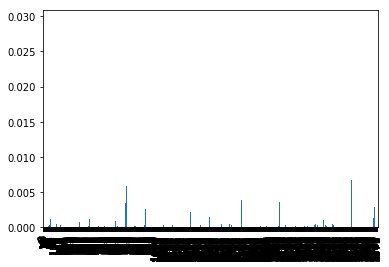

In [24]:
# Feature importance
pd.Series(xgbr.feature_importances_).plot(kind='bar')

#### 결론
- Decision tree와 SVM 같은 경우 parameter 값을 계속 조정해 봤지만 성능이 잘 올라가지 않았다.
- 학습 시간이 제일 오래 걸렸지만(4시간 30분), f1_score가 약 0.779로 Xgboost의 성능이 가장 좋았다.
- Neural network는 layer를 더 쌓고 계속 조절해도 Xgboost 보다는 성능이 좋아지지는 않았다. 하지만 0.01프로 차이이고, grid search를 쓰지 않았을때 Xgboost가 대략 50분 정도 걸렸던 것을 생각하면 Neural network 빠른 속도로 좋은 성능을 내는 모델이라 생각된다. (뉴럴네트워크의 layer를 100개 이상 쌓는경우 속도가 더 느려지겠지만, 레이어를 늘려도 성능 차이가 크게 없어서 layer를 더이상 늘리지 않았다.)

## Case2) Using PCA

1. 각 Ingredient를 column으로 변경한 뒤 PCA를 통해 차원을 축소한다.
2. tfidfVectorize를 이용하여 학습을 했을 때, f1 score가 가장 높았던 Xgboost와 Neural-network 이용하여 학습한다.

## I. ingredients column의 recipe를 colum으로 변경하기

In [6]:
# 1. all_ingredients set에 ingredients들을 담는다.
all_ingredients = set()
df['ingredients'].apply(lambda x : [all_ingredients.add(i) for i in list(x)])
#print(all_ingredients)

# 'ingredient' columns를 새로 만들면서, 각 ingredient가 해당 row의 recipe에 들어 있으면 True, 그렇지 않으면 False를 반환하게 함
for ingredient in all_ingredients:
    df[ingredient] = df['ingredients'].apply(lambda x : ingredient in x)
    
len(df.columns)

6316

In [7]:
%%time

column_list = []
for col in df.columns:
    column_list.append(col)
    
column_list.remove('id')
column_list.remove('ingredients')
column_list.remove('cuisine')

len(column_list)
print(column_list[:10])

df[column_list] = df[column_list].astype(int) # False는 0으로, True는 1로

['', 'vanilla lowfat ic cream', 'won ton skins', 'vegan coffee creamer', 'cavolo nero', 'marjoram', 'whole turkey', 'coconut meat', 'baby bok choy', 'boy choy']
Wall time: 9min 16s


In [8]:
# Copy
df_dummy = df.copy()

# 'id'와 'ingredients' columns는 더이상 필요가 없으므로 지운다.
del df_dummy['id']
del df_dummy['ingredients']

# 'cuisine' column을 지우기 위해 df_dummy를 copy
df_features = df_dummy.copy()

del df_features['cuisine']
df_features.tail(1)

vanilla lowfat ic cream  won ton skins  vegan coffee creamer  \
39773  0                        0              0                     0   

       cavolo nero  marjoram  whole turkey  coconut meat  baby bok choy  \
39773            0         0             0             0              0   

       boy choy  melted butter  mizkan oigatsuo tsuyu soup base  \
39773         0              0                                0   

       sweet  sour stir fry sauce  low sodium jarred chicken soup base  \
39773                           0                                    0   

       fat free less sodium vegetable broth  reduced sodium black beans  \
39773                                     0                           0   

       soda bread  collard greens  black tea leaves  honey mustard  fine salt  \
39773           0               0                 0              0          0   

       tart filling  oatmeal cookie mix  vanilla lowfat  yogurt  efu noodl  \
39773             0                   0                       0          0   

       cuttlefish  large egg whites  monkfish fillets  mung bean noodles  \
39773           0                 0                 0                  0   

       spanish paprika  dill pickles  fat free cream cheese  cassava meal  \
39773                0             0                      0             0   

       pure wesson vegetable oil  hamburger  cross rib roast  okra  mein  \
39773                          0          0                0     0     0   

       bean dip  plain chocolate  emmenthal  hot italian pork sausage  filo  \
39773         0                0          0                         0     0   

       regular sugar  kikkoman less sodium soy sauce  unbaked pie crusts  \
39773              0                               0                   0   

       ham steak  pink lentil  marmalade  pistou  rub seasoning  \
39773          0            0          0       0              0   

       scallion greens  dried black mushrooms  orange segments  red vermouth  \
39773                0                      0                0             0   

       toasted buns  cane sugar  konnyaku  pork countrystyle ribs  \
39773             0           0         0                       0   

       reducedfat sour cream  soya flour  corn oil  baking spray  fuji apple  \
39773                      0           0         0             0           0   

       praline liqueur  espresso beans  ginger  glutenfree tamari  \
39773                0               0       0                  0   

       knudsen sour cream  dried hibiscus blossoms  dried cornhusks  pepper  \
39773                   0                        0                0       0   

       chicken stock cubes  mint  cabbage  salsify  vegetable stock  \
39773                    0     0        0        0                0   

       cheese sticks  pancit bihon  bean curd stick  oyster mushrooms  \
39773              0             0                0                 0   

       chicken chorizo sausages  grapeseed oil  leek  dried chile  \
39773                         0              0     0            0   

       reduced sodium vegetable stock  gelato  calamari steak  \
39773                               0       0               0   

       goya extra virgin olive oil  peanut oil  reducedfat cheese  \
39773                            0           0                  0   

       broad beans  cockle  chinese black bean  calamansi  manouri  \
39773            0       0                   0          0        0   

       black salt  cranberry juice  whole wheat english muffins  red snapper  \
39773           0                0                            0            0   

       large snails  dried kidney beans  sauerkraut juice  sparkling wine  \
39773             0                   0                 0               0   

       red bartlett pears  saltpeter  bénédictine  tamarind paste  \
39773                   0          0            0              

## II. Label Encoding

In [9]:
Lec = LabelEncoder()
train_target_value = Lec.fit_transform(df_dummy['cuisine'].values)

print(train_target_value.shape)

(39774,)


In [10]:
print(train_target_value[:10])

[ 6 16  4  7  7 10 17  9 13  9]


In [11]:
print(Lec.classes_)

['brazilian' 'british' 'cajun_creole' 'chinese' 'filipino' 'french' 'greek'
 'indian' 'irish' 'italian' 'jamaican' 'japanese' 'korean' 'mexican'
 'moroccan' 'russian' 'southern_us' 'spanish' 'thai' 'vietnamese']


## III. Data split

In [12]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(df_features, train_target_value)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(29830, 6313) (9944, 6313) (29830,) (9944,)


## IV. PCA

In [13]:
%%time
# fit method를 호출하여 주성분을 찾는다. 주성분은 200개로 한다.
pca = PCA(n_components=200, whiten=True, random_state=0).fit(X_train)
# transform method를 호출해 데이터를 회전시키고 차원을 축소
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("X_train_pca.shape: {}".format(X_train_pca.shape))

X_train_pca.shape: (29830, 200)
Wall time: 58.9 s


In [14]:
pca.components_

array([[  1.84907336e-03,  -3.12405873e-05,  -3.43174037e-05, ...,
          1.20280073e-04,   0.00000000e+00,   8.72824958e-05],
       [ -2.18826586e-03,   1.50073264e-04,   4.00225001e-05, ...,
         -5.46485296e-05,  -0.00000000e+00,  -2.51030246e-04],
       [ -1.33514264e-03,  -9.16518834e-06,   1.32218211e-04, ...,
         -9.03499373e-05,  -0.00000000e+00,  -2.40457432e-06],
       ..., 
       [  6.07595408e-02,  -6.64677030e-05,  -7.13772413e-06, ...,
          4.06535041e-04,   0.00000000e+00,   8.36529348e-04],
       [ -8.90132987e-03,   1.42981439e-04,  -1.15252266e-04, ...,
          8.47798708e-05,  -0.00000000e+00,  -6.80762047e-04],
       [  2.93101444e-02,  -5.37989236e-07,   1.72455454e-04, ...,
          3.10244290e-04,   0.00000000e+00,   9.52365397e-04]])

이제 새로운 data는 처음 200개의 주성분에 해당하는 특성을 갖는다.

## V. Model Selection

### 1. Xgboost

In [15]:
def Xgboost_():
    xgbr = xgb.XGBClassifier(
        n_estimators = 400,
        max_depth = 5
    ).fit(X_train_pca, y_train)
        
    cuisine = ['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek',
               'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan',
               'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']

    print (classification_report(y_test, xgbr.predict(X_test_pca), digits=4, target_names=cuisine))
    return print("Test score : {}".format(xgbr.score(X_test_pca, y_test)))

In [16]:
%%time
Xgboost = Xgboost_()

              precision    recall  f1-score   support

   brazilian     0.8085    0.3455    0.4841       110
     british     0.4783    0.1571    0.2366       210
cajun_creole     0.8062    0.6165    0.6987       425
     chinese     0.7058    0.8269    0.7616       676
    filipino     0.7281    0.4256    0.5372       195
      french     0.4499    0.4962    0.4719       651
       greek     0.8092    0.5204    0.6335       269
      indian     0.8119    0.8437    0.8275       742
       irish     0.5769    0.1775    0.2715       169
     italian     0.6780    0.8624    0.7592      1992
    jamaican     0.8714    0.4841    0.6224       126
    japanese     0.7280    0.5600    0.6330       325
      korean     0.8015    0.5172    0.6287       203
     mexican     0.8188    0.8897    0.8528      1605
    moroccan     0.8333    0.5867    0.6886       196
     russian     0.7576    0.2033    0.3205       123
 southern_us     0.5317    0.7129    0.6091      1059
     spanish     0.6705    

### 2. Neural Network

In [19]:
def Neural_network_():
    nn = MLPClassifier(hidden_layer_sizes=(400,500,400))
    nn.fit(X_train_pca, y_train)
    
    cuisine = ['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek',
               'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan',
               'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']

    print (classification_report(y_test, nn.predict(X_test_pca), digits=4, target_names=cuisine))
    return print("Test score : {}".format(nn.score(X_test_pca, y_test)))

In [20]:
%%time
Neural_Network = Neural_network_()

              precision    recall  f1-score   support

   brazilian     0.7121    0.3534    0.4724       133
     british     0.2920    0.1970    0.2353       203
cajun_creole     0.5250    0.6848    0.5943       368
     chinese     0.7247    0.7480    0.7362       623
    filipino     0.5724    0.4860    0.5257       179
      french     0.4347    0.4695    0.4514       688
       greek     0.6353    0.5704    0.6011       284
      indian     0.7977    0.8089    0.8033       785
       irish     0.3408    0.3631    0.3516       168
     italian     0.7739    0.7330    0.7529      1966
    jamaican     0.6053    0.4759    0.5328       145
    japanese     0.6512    0.5910    0.6197       357
      korean     0.6223    0.6257    0.6240       187
     mexican     0.8101    0.8733    0.8405      1602
    moroccan     0.6667    0.6479    0.6571       213
     russian     0.4600    0.3433    0.3932       134
 southern_us     0.5885    0.6169    0.6024      1099
     spanish     0.3210    

## VI. Conclusion

- 성능을 더 높이고 싶어서 시도해보았지만, PCA를 이용하여 축소된 데이터를 가지고 학습시킨 경우 더 성능이 좋지 않았다.
- PCA가 잘 작동할 때는 데이터에 중복이 많은 경우인데 중복된 컬럼이 별로 없었기 때문에 PCA로 요약하는 게 의미가 없어진거라고 판단했다.

## Case3) Simple Bot

- user가 선호하는 음식을 선택하면 그것을 통해서 user가 어느나라 음식을 선호하는지 파악하고, recipe를 추천하는 기능을 구현하고 싶었으나 각 recipe의 음식 이름을 찾을 수가 없었다. 그래서 방향을 전환하여 user가 cuisine을 선택하면 word2vec을 이용해서 user가 선택한 cuisine과 가장 유사한 ingredients를 알려주는 간단한 봇을 구현했다.

## I. word2vec 적용

In [6]:
""" 

logic : df['cuisine']과 df['ingredients']를 리스트 형식으로 만들고 싶지만, 
        df['ingredients']가 각각 리스트 형식으로 되어있기 때문에 몇가지 작업이 필요하다.

1. df['ingredients'] 즉, 각 recipe 리스트를 하나의 리스트(called ingredient_list)에 넣는다.
   ingredient_list를 data frame에 넣어준다 (왜? 각 ingredient를 column으로 만들어 주기 위해)
2. df['cuisine']과 ingredient_list를 column으로 합친다. 그러면 하나의 data frame이 만들어짐
3. iterrows() 함수를 이용하여 각 row를 list로 만들어 준다.

"""

""" 1번 작업 """
ingredient_list = []

for elements in df['ingredients']:
    ingredient_list.append(elements)
    
## ingredient_list의 각 원소를 리스트 형식
#ingredient_list

ingredient_df = pd.DataFrame(ingredient_list)
#ingredient_df

""" 2번 작업 """
cuisine_list = []

for element in df['cuisine']:
    cuisine_list.append(element)

ingredient_df.insert(0, "cuisines", cuisine_list)
#ingredient_df.tail(2)

""" 3번 작업 """
temp = []

for row in ingredient_df.iterrows():
    index, data = row
    temp.append(data.tolist())
    
#temp

""" 예상치 못하게, temp안에 None 값이 들어 간것을 확인했다. None 값을 제거한다. """
new_temp = []

for list_element in temp:
    new_element = [x for x in list_element if x is not None]
    new_temp.append(new_element)
    
#new_temp[0]

""" word2vec 학습 """
model = word2vec.Word2Vec(new_temp, workers = 4, 
                         size = 300, min_count = 3, window = 10)

model.init_sims(replace=True)

# 학습이 잘 되었는지 확인
model.most_similar('korean')

[('sesame oil', 0.9166130423545837),
 ('mirin', 0.9005289673805237),
 ('japanese', 0.8945342302322388),
 ('gochujang base', 0.8928666114807129),
 ('toasted sesame seeds', 0.8906885981559753),
 ('chinese', 0.8844469785690308),
 ('toasted sesame oil', 0.8794854283332825),
 ('soy bean paste', 0.8601735830307007),
 ('sake', 0.8579459190368652),
 ('rice wine', 0.8532756567001343)]

In [7]:
cuisine_dict = dict(df.cuisine.value_counts().items())
cuisine_list = list(cuisine_dict.keys())

## II. Simple Bot

In [10]:
print("Bot: " 
      + "\t" + "I can tell you common ingredients often used in the country." 
      + "\n" + "\t" + "What kind of cuisine do you want to know?" 
      + "\n" + "\t" + "Cuisine list is here."
      + "\n" + "\t" + "====================[CUISINE LISE]===================="
      + "\n" + "\t" + "italian, mexican, southern_us, indian, chinese"
      + "\n" + "\t" + "french, cajun_creole, thai, japanese, greek"
      + "\n" + "\t" + "spanish, korean, vietnamese', moroccan, british"
      + "\n" + "\t" + "filipino, irish, jamaican, russian, brazilian"
      + "\n" + "\t" + "======================================================")
    
while True:

    user_question = input("User: " + "\t").strip()
    user_question_lower = user_question.lower()
    
    ingredient_list = []
    for cuisine in cuisine_list:
        
        if cuisine in user_question:
            for i in model.most_similar(cuisine):
                if i[0] not in cuisine_list:
                    ingredient_list.append(i[0])
            print("Bot: " + "\t" + "commonly used ingredients in {} food are {}".format(cuisine, ingredient_list)
                          + "\n" + "\t" + "Do you want to know more? yes or no")
                        
    if user_question == "":
        print("Bot: "+ "\t" + "What kind of cuisine do you want to know?"
                   + "\t" + "I can tell you common ingredients often used in the country." 
                   + "\n" + "\t" + "What kind of cuisine do you want to know?" 
                   + "\n" + "\t" + "Cuisine list is here."
                   + "\n" + "\t" + "====================[CUISINE LISE]===================="
                   + "\n" + "\t" + "italian, mexican, southern_us, indian, chinese"
                   + "\n" + "\t" + "french, cajun_creole, thai, japanese, greek"
                   + "\n" + "\t" + "spanish, korean, vietnamese', moroccan, british"
                   + "\n" + "\t" + "filipino, irish, jamaican, russian, brazilian"
                   + "\n" + "\t" + "======================================================")
        
    elif user_question == "yes":
        print("Bot: "+ "\t" + "What kind of cuisine do you want to know?"
                   + "\t" + "I can tell you common ingredients often used in the country." 
                   + "\n" + "\t" + "What kind of cuisine do you want to know?" 
                   + "\n" + "\t" + "Cuisine list is here."
                   + "\n" + "\t" + "====================[CUISINE LISE]===================="
                   + "\n" + "\t" + "italian, mexican, southern_us, indian, chinese"
                   + "\n" + "\t" + "french, cajun_creole, thai, japanese, greek"
                   + "\n" + "\t" + "spanish, korean, vietnamese', moroccan, british"
                   + "\n" + "\t" + "filipino, irish, jamaican, russian, brazilian"
                   + "\n" + "\t" + "======================================================")
                        
    elif user_question == "no":
        print("Bot: "+ "\t" + "See you again. Bye.")
        break

Bot: 	I can tell you common ingredients often used in the country.
	What kind of cuisine do you want to know?
	Cuisine list is here.
	====================[CUISINE LISE]====================
	italian, mexican, southern_us, indian, chinese
	french, cajun_creole, thai, japanese, greek
	spanish, korean, vietnamese', moroccan, british
	filipino, irish, jamaican, russian, brazilian
User: 	jamaican
Bot: 	commonly used ingredients in jamaican food are ['allspice', 'pickapeppa sauce', 'scotch bonnet chile', 'chicken pieces', 'malt vinegar', 'white vinegar', 'mustard powder', 'chicken thighs', 'cayenne pepper', 'apple cider vinegar']
	Do you want to know more? yes or no
User: 	no
Bot: 	See you again. Bye.


## III. Conclusion

- seq2seq, 마르코프체인 등 챗봇을 구현할 수 있는 알고리즘을 적용할 수 있도록 더 공부하여 시도해 볼 것이다.